# Netgen-Poreflow
Project for AGRON 935

In [7]:
#importing required modules
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [8]:
starttime= datetime.datetime.now()

networks_sizes_list = [10, 20,30, 40, 60] #network sizes for our simulations
iteration = 10

permeability_array = np.zeros((len(networks_sizes_list),len(range(iteration))))
formationfactor_array = np.zeros((len(networks_sizes_list),len(range(iteration))))
porosity_array = np.zeros((len(networks_sizes_list),len(range(iteration))))


# loop for changing the network size and creating netgenInput file and running the poreflow (fluid flow):
for i in range(len(networks_sizes_list)):
    for j in range(iteration):
        network_size = networks_sizes_list[i] 
        network_3d = str(network_size)+ " " +str(network_size)+ " "+ str(network_size)
# this is how I create my input file, pretty easy and straight forward but not sure if there is 
# another way to do it.Basically I just write every element of this list into a line into the 'netgenInput.dat' file which is my input file.
        input_text = ["distrib % Base file \n",
        network_3d,"\n",
        "0.1 10 0.2 6 % Min throat radius, max throat radius, delta exp, eta exp \n",
        "100 100 0.3 2.0 % Min throat length, max throat length, delta exp, eta exp \n",
        "0 0 0.2 3.0 % Min aspect ratio, max aspect ratio, delta exp, eta exp \n",
        "0.001 0.04811 0.8 1.6 % Triangles: Min G, max G, delta exp, eta exp \n",
        "0 1 % Pores: proportion of square and circular pores \n",
        "0 1 % Throats: proportion of square and circular throats \n",
        "0 % Proportion of pore volume occupied by clay \n",
        "6 % Average connection number <= 6 \n",
        "T % Use periodic boundary conditions \n"]

        f= open('netgenInput.dat','w')
        f.writelines(input_text)
        f.close()

        os.system("netgen_win32.exe netgenInput.dat")
        os.system("poreflow_win32.exe poreflowInput.dat")

        output = open("poreflowInput.prt")
        output_lines = output.readlines()
        if len(output_lines) < 26:
            permeability_array[i][j] = np.nan
            porosity_array[i][j] = np.nan
            formationfactor_array[i][j] = np.nan
            
        elif "permeability" in output_lines[25].split():
            permeability_line = output_lines[25].split()
            permeability_array[i][j] = permeability_line[-1]

            porosity_line = output_lines[22].split()
            porosity_array[i][j] = porosity_line[-1]

            formationfactor_line = output_lines[26].split()
            formationfactor_array[i][j] = formationfactor_line[-1]
        else:
            permeability_line = output_lines[33].split()
            permeability_array[i][j] = permeability_line[-1]

            porosity_line = output_lines[30].split()
            porosity_array[i][j] = porosity_line[-1]

            formationfactor_line = output_lines[34].split()
            formationfactor_array[i][j] = formationfactor_line[-1]
                    
# print(permeability_array)
# print(formationfactor_array)
# print(porosity_array)

permeability_means = np.nanmean(permeability_array, axis=1)
formationfactor_means = np.nanmean(formationfactor_array, axis=1)
porosity_means = np.nanmean(porosity_array, axis=1)

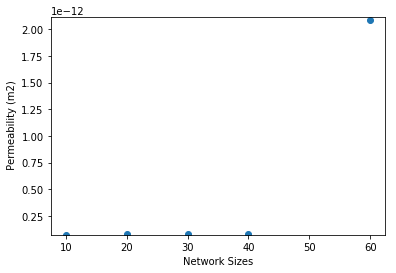

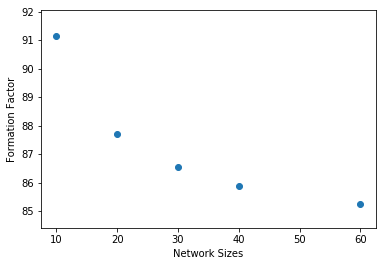

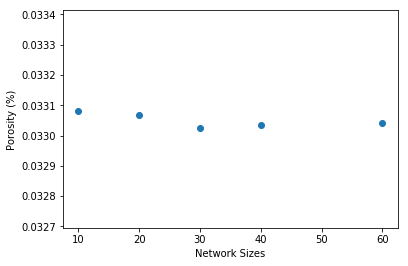

In [9]:
# What is the best way to set the ylim? I did it as you see below but not too happy with it. 

plt.scatter(networks_sizes_list, permeability_means, )
plt.xlabel('Network Sizes')
plt.ylabel(' Permeability (m2)')
# I set mt y axis this way
plt.ylim(0.99*min(permeability_means), 1.01*max(permeability_means))
plt.show()

plt.scatter(networks_sizes_list, formationfactor_means)
plt.xlabel('Network Sizes')
plt.ylabel('Formation Factor')
plt.ylim(0.99*min(formationfactor_means), 1.01*max(formationfactor_means))
plt.show()

plt.scatter(networks_sizes_list, porosity_means)
plt.xlabel('Network Sizes')
plt.ylabel('Porosity (%)')
plt.ylim(0.99*min(porosity_means), 1.01*max(porosity_means))
plt.show()

In [10]:
endtime= datetime.datetime.now()
endtime -starttime

datetime.timedelta(seconds=3094, microseconds=372110)

In [ ]:
# Matlab took around 4200 seconds